### 1. Settings

In [1]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch
import pandas as pd
from tqdm.auto import tqdm
import numpy as np 
from torch.utils.data import DataLoader

import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
np.random.seed(42) 
np.random.rand(5)

array([0.37454012, 0.95071431, 0.73199394, 0.59865848, 0.15601864])

In [3]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


In [4]:
lr = 1e-5
epochs = 150
batch_size = 64

### 2. Data 

##### 1) data set 

In [5]:
class train_dataset(torch.utils.data.Dataset):
    def __init__(self, x_dir, y_dir, transform=None):
        super().__init__()
        self.transforms = transform
        self.x_img = x_dir
        self.y_img = y_dir   

    def __len__(self):
        return len(self.x_img)

    def __getitem__(self, idx):
        x_img = self.x_img[idx]
        y_img = self.y_img[idx]

        
        X_img = cv2.imread(x_img)
        Y_img = cv2.imread(y_img)
        
        X_img= cv2.cvtColor(X_img, cv2.COLOR_BGR2GRAY)
        Y_img= cv2.cvtColor(Y_img, cv2.COLOR_BGR2GRAY)
        # print(X_img.shape)
        
        X_img=np.expand_dims(X_img, 2)
        Y_img=np.expand_dims(Y_img, 2)
        # print(X_img.shape)

        if self.transforms != None:
            aug = self.transforms(image=X_img, label=Y_img)
            x_image = aug['image']
            y_image = aug['label']
            
            # print(x_image.shape)
            x_image = np.transpose(x_image, (2, 0, 1))
            y_image = np.transpose(y_image, (2, 0, 1))
            
        return x_image, y_image

In [6]:
train_csv = pd.read_csv('./data/train.csv')
valid_csv = pd.read_csv('./data/validation.csv')

In [7]:
# 1718장
train_input_files = train_csv['input']
train_label_files = train_csv['label']

# 400장
valid_input_files = valid_csv['input']
valid_label_files = valid_csv['label']

##### 2) transform 

In [8]:
import albumentations as alb
import albumentations.pytorch
train_augmetations = albumentations.Compose([
                              alb.augmentations.crops.transforms.CenterCrop(256, 256),
                              # albumentations.Resize(256, 256),
                              alb.Rotate(limit=45),
                              alb.augmentations.transforms.Normalize(mean=(0.5), std=(0.5))
                              ],additional_targets={'label':'image'})

valid_augmetations = albumentations.Compose([
                              alb.augmentations.crops.transforms.CenterCrop(256, 256),
                              # albumentations.Resize(256, 256),
                              # alb.Rotate(limit=30),
                              alb.augmentations.transforms.Normalize(mean=(0.5), std=(0.5))
                              ],additional_targets={'label':'image'})

In [9]:
train_data = train_dataset(train_input_files, train_label_files, transform = train_augmetations)
valid_data = train_dataset(valid_input_files, valid_label_files, transform = valid_augmetations)

In [10]:
data = train_data.__getitem__(0)
print(data[0].shape)

(1, 256, 256)


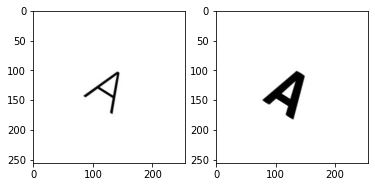

In [11]:
inp = data[0]
lab = data[1]

plt.subplot(121)
plt.imshow(np.transpose(inp, (1, 2, 0)), cmap = 'gray')
plt.subplot(122)
plt.imshow(np.transpose(lab, (1, 2, 0)), cmap = 'gray')
plt.show()

##### 3) data loader 

In [12]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

In [13]:
a, b = next(iter(train_loader))

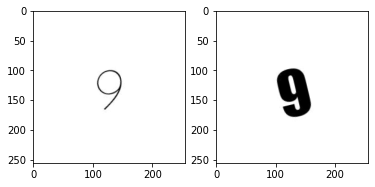

In [14]:
plt.subplot(121)
plt.imshow(np.transpose(a[0], (1, 2, 0)), cmap = 'gray')
plt.subplot(122)
plt.imshow(np.transpose(b[0], (1, 2, 0)), cmap = 'gray')
plt.show()

### 3. Building the Unet

In [15]:
import torch.nn as nn
import torch
import torch.utils as utils
import torch.nn.init as init
import torch.utils.data as data
import torchvision.utils as v_utils
import torchvision.datasets as dset
import torchvision.transforms as transforms

In [16]:
class MyUnet(nn.Module):
    def __init__(self):
        super(MyUnet,self).__init__()
        
        def ConvBox(in_channels, out_channels, k=3, s=1, p=1, b=True):
            # conv layer 정의
            layers  = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=k, stride=s, padding=p, bias=b),
                nn.BatchNorm2d(num_features=out_channels),
                nn.LeakyReLU()
            )
            return layers
        
        def ConvTransBox(in_channels, out_channels):
            layers = nn.Sequential(
                nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding = 1),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU()
            )
            return layers

        def maxpool():
            maxpool = nn.MaxPool2d(2, 2, padding = 0)
            return maxpool
        
        
        # contracting path
        self.d1_1 = ConvBox(in_channels=1, out_channels=8)
        self.d1_2 = ConvBox(in_channels=8, out_channels=8)
        self.p_1 = maxpool()
        
        self.d2_1 = ConvBox(in_channels=8, out_channels=16)
        self.d2_2 = ConvBox(in_channels=16, out_channels=16)
        self.p_2 = maxpool()
        
        self.d3_1 = ConvBox(in_channels=16, out_channels=32)
        self.d3_2 = ConvBox(in_channels=32, out_channels=32)
        self.p_3 = maxpool()
        
        self.d4_1 = ConvBox(in_channels=32, out_channels=64)
        self.d4_2 = ConvBox(in_channels=64, out_channels=64)
        self.p_4 = maxpool()
        
        self.d5_1 = ConvBox(in_channels=64, out_channels=128)
        self.d5_2 = ConvBox(in_channels=128, out_channels=128)
        self.p_5 = maxpool()

        self.d_6 = ConvBox(in_channels=128, out_channels=256)

        # ---------------------------------------------------
        
        self.u_6 = ConvBox(in_channels=256, out_channels=128)
        
        self.up_5 = ConvTransBox(in_channels=128, out_channels=128)
        self.u5_2 = ConvBox(in_channels=2*128, out_channels=128)
        self.u5_1 = ConvBox(in_channels=128, out_channels=64)

        self.up_4 = ConvTransBox(in_channels=64, out_channels=64)
        self.u4_2 = ConvBox(in_channels=2*64, out_channels=64)
        self.u4_1 = ConvBox(in_channels=64, out_channels=32)

        self.up_3 = ConvTransBox(in_channels=32, out_channels=32)
        self.u3_2 = ConvBox(in_channels=2*32, out_channels=32)
        self.u3_1 = ConvBox(in_channels=32, out_channels=16)
        
        self.up_2 = ConvTransBox(in_channels=16, out_channels=16)
        self.u2_2 = ConvBox(in_channels=2*16, out_channels=16)
        self.u2_1 = ConvBox(in_channels=16, out_channels=8)
        
        self.up_1 = ConvTransBox(in_channels=8, out_channels=8)
        self.u1_2 = ConvBox(in_channels=2*8, out_channels=8)
        self.u1_1 = ConvBox(in_channels=8, out_channels=8)
        
        # self.out = nn.Conv2d(in_channels=8, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)
        self.out = nn.Sequential(
                    nn.Conv2d(in_channels=8, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True),
                    nn.Tanh(),  #필수는 아님
                )
        
    def forward(self, input):
        d1_1 = self.d1_1(input)
        d1_2 = self.d1_2(d1_1)
        p_1 = self.p_1(d1_2)
        
        d2_1 = self.d2_1(p_1)
        d2_2 = self.d2_2(d2_1)
        p_2 = self.p_2(d2_2)
        
        d3_1 = self.d3_1(p_2)
        d3_2 = self.d3_2(d3_1)
        p_3 = self.p_3(d3_2)
        
        d4_1 = self.d4_1(p_3)
        d4_2 = self.d4_2(d4_1)
        p_4 = self.p_4(d4_2)
        
        d5_1 = self.d5_1(p_4)
        d5_2 = self.d5_2(d5_1)
        p_5 = self.p_5(d5_2)
        
        d_6 = self.d_6(p_5)
        
        # ---------------------------------------------

        u_6 = self.u_6(d_6)
        
        up_5 = self.up_5(u_6)
        # print(up_5.shape)
        # print(d5_2.shape)
        concat_5 = torch.cat([up_5, d5_2], dim=1)
        u5_2 = self.u5_2(concat_5)
        u5_1 = self.u5_1(u5_2)
        
        up_4 = self.up_4(u5_1)
        concat_4 = torch.cat([up_4, d4_2], dim=1)
        u4_2 = self.u4_2(concat_4)
        u4_1 = self.u4_1(u4_2)
        
        up_3 = self.up_3(u4_1)
        concat_3 = torch.cat([up_3, d3_2], dim=1)
        u3_2 = self.u3_2(concat_3)
        u3_1 = self.u3_1(u3_2)
        
        up_2 = self.up_2(u3_1)
        concat_2 = torch.cat([up_2, d2_2], dim=1)
        u2_2 = self.u2_2(concat_2)
        u2_1 = self.u2_1(u2_2)
        
        up_1 = self.up_1(u2_1)
        concat_1 = torch.cat([up_1, d1_2], dim=1)
        u1_2 = self.u1_2(concat_1)
        u1_1 = self.u1_1(u1_2)
        
        out = self.out(u1_1)
        
        return out

In [17]:
model = MyUnet()

model = model.to(device)

loss_func = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum = 0.99)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, gamma = 0.1)

###  4. Training & Validation

In [18]:
train_loss = torch.zeros(epochs) # train loss 저장할 공간
valid_loss = torch.zeros(epochs) # validation loss 저장할 공간

valid_loss_min = np.Inf
# validation loss가 가장 낮은 모델을 저장하기 위해 초기 validation loss를 무한대로 설정해놓고,
# valid_loss_min 보다 더 작은 loss가 나왔을 때 모델을 저장하게 됨

for e in range(epochs):

    model.train()
    for image, label in tqdm(train_loader):
        optimizer.zero_grad()
        image = image.to(device) 
        label = label.to(device)
        
        output = model(image)
        loss = loss_func(output, label)
        # 얇은 글씨가 굵은 글씨가 되도록 업데이트 하기 위해 label로 굵은 글씨를 넣어줌
        loss.backward()
        optimizer.step()
        train_loss[e] += loss.item()
        
    train_loss[e] /= len(train_loader)
        
    model.eval()
    with torch.no_grad():
        for image, label in tqdm(valid_loader):

            image = image.to(device)
            label = label.to(device)
            
            output = model(image)
            loss = loss_func(output, label)
            valid_loss[e] += loss.item()
    
    valid_loss[e] /= len(valid_loader)
    # scheduler.step()
    
    print('Epoch: {} \t Training Loss: {:.6f} \tValidation Loss: {:.6f}'.format(e, train_loss[e], valid_loss[e]))
    
    if valid_loss[e] <= valid_loss_min: # 현재의 validation loss가 이전의 validation loss보다 작을 때 모델 저장
        print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(
            valid_loss_min, valid_loss[e]))
        torch.save(model, './model/unet_L1loss_sgd3.pkl')
        valid_loss_min = valid_loss[e]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 0 	 Training Loss: 0.926063 	Validation Loss: 0.933980
Validation loss decreased (inf --> 0.933980). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1 	 Training Loss: 0.913099 	Validation Loss: 0.892250
Validation loss decreased (0.933980 --> 0.892250). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 2 	 Training Loss: 0.890253 	Validation Loss: 0.880320
Validation loss decreased (0.892250 --> 0.880320). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 3 	 Training Loss: 0.859836 	Validation Loss: 0.849845
Validation loss decreased (0.880320 --> 0.849845). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 4 	 Training Loss: 0.825293 	Validation Loss: 0.814891
Validation loss decreased (0.849845 --> 0.814891). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 5 	 Training Loss: 0.789832 	Validation Loss: 0.778137
Validation loss decreased (0.814891 --> 0.778137). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 6 	 Training Loss: 0.756351 	Validation Loss: 0.744415
Validation loss decreased (0.778137 --> 0.744415). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 7 	 Training Loss: 0.724863 	Validation Loss: 0.712461
Validation loss decreased (0.744415 --> 0.712461). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 8 	 Training Loss: 0.695153 	Validation Loss: 0.683227
Validation loss decreased (0.712461 --> 0.683227). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 9 	 Training Loss: 0.667083 	Validation Loss: 0.654931
Validation loss decreased (0.683227 --> 0.654931). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 10 	 Training Loss: 0.640566 	Validation Loss: 0.627936
Validation loss decreased (0.654931 --> 0.627936). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 11 	 Training Loss: 0.615481 	Validation Loss: 0.602436
Validation loss decreased (0.627936 --> 0.602436). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 12 	 Training Loss: 0.591673 	Validation Loss: 0.579563
Validation loss decreased (0.602436 --> 0.579563). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 13 	 Training Loss: 0.568985 	Validation Loss: 0.557277
Validation loss decreased (0.579563 --> 0.557277). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 14 	 Training Loss: 0.547234 	Validation Loss: 0.535505
Validation loss decreased (0.557277 --> 0.535505). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 15 	 Training Loss: 0.526528 	Validation Loss: 0.516008
Validation loss decreased (0.535505 --> 0.516008). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 16 	 Training Loss: 0.506647 	Validation Loss: 0.495762
Validation loss decreased (0.516008 --> 0.495762). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 17 	 Training Loss: 0.487665 	Validation Loss: 0.476606
Validation loss decreased (0.495762 --> 0.476606). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 18 	 Training Loss: 0.469606 	Validation Loss: 0.458714
Validation loss decreased (0.476606 --> 0.458714). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 19 	 Training Loss: 0.452388 	Validation Loss: 0.442516
Validation loss decreased (0.458714 --> 0.442516). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 20 	 Training Loss: 0.436124 	Validation Loss: 0.426270
Validation loss decreased (0.442516 --> 0.426270). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 21 	 Training Loss: 0.420583 	Validation Loss: 0.411644
Validation loss decreased (0.426270 --> 0.411644). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 22 	 Training Loss: 0.405946 	Validation Loss: 0.396801
Validation loss decreased (0.411644 --> 0.396801). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 23 	 Training Loss: 0.392018 	Validation Loss: 0.382653
Validation loss decreased (0.396801 --> 0.382653). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 24 	 Training Loss: 0.378773 	Validation Loss: 0.370715
Validation loss decreased (0.382653 --> 0.370715). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 25 	 Training Loss: 0.366209 	Validation Loss: 0.359123
Validation loss decreased (0.370715 --> 0.359123). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 26 	 Training Loss: 0.354365 	Validation Loss: 0.347657
Validation loss decreased (0.359123 --> 0.347657). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 27 	 Training Loss: 0.343065 	Validation Loss: 0.335173
Validation loss decreased (0.347657 --> 0.335173). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 28 	 Training Loss: 0.332400 	Validation Loss: 0.325747
Validation loss decreased (0.335173 --> 0.325747). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 29 	 Training Loss: 0.322158 	Validation Loss: 0.315332
Validation loss decreased (0.325747 --> 0.315332). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 30 	 Training Loss: 0.312445 	Validation Loss: 0.305017
Validation loss decreased (0.315332 --> 0.305017). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 31 	 Training Loss: 0.303230 	Validation Loss: 0.296877
Validation loss decreased (0.305017 --> 0.296877). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 32 	 Training Loss: 0.294531 	Validation Loss: 0.288872
Validation loss decreased (0.296877 --> 0.288872). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 33 	 Training Loss: 0.286255 	Validation Loss: 0.281441
Validation loss decreased (0.288872 --> 0.281441). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 34 	 Training Loss: 0.278388 	Validation Loss: 0.272419
Validation loss decreased (0.281441 --> 0.272419). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 35 	 Training Loss: 0.270867 	Validation Loss: 0.265308
Validation loss decreased (0.272419 --> 0.265308). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 36 	 Training Loss: 0.263740 	Validation Loss: 0.258552
Validation loss decreased (0.265308 --> 0.258552). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 37 	 Training Loss: 0.256974 	Validation Loss: 0.251850
Validation loss decreased (0.258552 --> 0.251850). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 38 	 Training Loss: 0.250459 	Validation Loss: 0.244866
Validation loss decreased (0.251850 --> 0.244866). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 39 	 Training Loss: 0.244326 	Validation Loss: 0.239808
Validation loss decreased (0.244866 --> 0.239808). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 40 	 Training Loss: 0.238432 	Validation Loss: 0.233891
Validation loss decreased (0.239808 --> 0.233891). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 41 	 Training Loss: 0.232783 	Validation Loss: 0.228531
Validation loss decreased (0.233891 --> 0.228531). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 42 	 Training Loss: 0.227404 	Validation Loss: 0.222704
Validation loss decreased (0.228531 --> 0.222704). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 43 	 Training Loss: 0.222273 	Validation Loss: 0.218633
Validation loss decreased (0.222704 --> 0.218633). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 44 	 Training Loss: 0.217409 	Validation Loss: 0.214415
Validation loss decreased (0.218633 --> 0.214415). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 45 	 Training Loss: 0.212654 	Validation Loss: 0.209415
Validation loss decreased (0.214415 --> 0.209415). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 46 	 Training Loss: 0.208172 	Validation Loss: 0.205072
Validation loss decreased (0.209415 --> 0.205072). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 47 	 Training Loss: 0.204012 	Validation Loss: 0.200152
Validation loss decreased (0.205072 --> 0.200152). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 48 	 Training Loss: 0.199830 	Validation Loss: 0.196070
Validation loss decreased (0.200152 --> 0.196070). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 49 	 Training Loss: 0.195809 	Validation Loss: 0.192344
Validation loss decreased (0.196070 --> 0.192344). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 50 	 Training Loss: 0.191966 	Validation Loss: 0.189055
Validation loss decreased (0.192344 --> 0.189055). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 51 	 Training Loss: 0.188340 	Validation Loss: 0.185523
Validation loss decreased (0.189055 --> 0.185523). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 52 	 Training Loss: 0.184919 	Validation Loss: 0.182740
Validation loss decreased (0.185523 --> 0.182740). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 53 	 Training Loss: 0.181507 	Validation Loss: 0.179562
Validation loss decreased (0.182740 --> 0.179562). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 54 	 Training Loss: 0.178255 	Validation Loss: 0.176164
Validation loss decreased (0.179562 --> 0.176164). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 55 	 Training Loss: 0.175180 	Validation Loss: 0.171861
Validation loss decreased (0.176164 --> 0.171861). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 56 	 Training Loss: 0.172143 	Validation Loss: 0.169837
Validation loss decreased (0.171861 --> 0.169837). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 57 	 Training Loss: 0.169329 	Validation Loss: 0.166768
Validation loss decreased (0.169837 --> 0.166768). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 58 	 Training Loss: 0.166508 	Validation Loss: 0.164675
Validation loss decreased (0.166768 --> 0.164675). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 59 	 Training Loss: 0.163786 	Validation Loss: 0.162303
Validation loss decreased (0.164675 --> 0.162303). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 60 	 Training Loss: 0.161333 	Validation Loss: 0.159602
Validation loss decreased (0.162303 --> 0.159602). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 61 	 Training Loss: 0.158796 	Validation Loss: 0.156704
Validation loss decreased (0.159602 --> 0.156704). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 62 	 Training Loss: 0.156373 	Validation Loss: 0.154253
Validation loss decreased (0.156704 --> 0.154253). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 63 	 Training Loss: 0.154014 	Validation Loss: 0.152875
Validation loss decreased (0.154253 --> 0.152875). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 64 	 Training Loss: 0.151718 	Validation Loss: 0.149780
Validation loss decreased (0.152875 --> 0.149780). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 65 	 Training Loss: 0.149604 	Validation Loss: 0.148800
Validation loss decreased (0.149780 --> 0.148800). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 66 	 Training Loss: 0.147430 	Validation Loss: 0.146236
Validation loss decreased (0.148800 --> 0.146236). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 67 	 Training Loss: 0.145497 	Validation Loss: 0.144175
Validation loss decreased (0.146236 --> 0.144175). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 68 	 Training Loss: 0.143419 	Validation Loss: 0.142488
Validation loss decreased (0.144175 --> 0.142488). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 69 	 Training Loss: 0.141562 	Validation Loss: 0.140811
Validation loss decreased (0.142488 --> 0.140811). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 70 	 Training Loss: 0.139663 	Validation Loss: 0.138763
Validation loss decreased (0.140811 --> 0.138763). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 71 	 Training Loss: 0.137901 	Validation Loss: 0.136802
Validation loss decreased (0.138763 --> 0.136802). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 72 	 Training Loss: 0.136098 	Validation Loss: 0.135250
Validation loss decreased (0.136802 --> 0.135250). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 73 	 Training Loss: 0.134472 	Validation Loss: 0.133540
Validation loss decreased (0.135250 --> 0.133540). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 74 	 Training Loss: 0.132794 	Validation Loss: 0.131487
Validation loss decreased (0.133540 --> 0.131487). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 75 	 Training Loss: 0.131176 	Validation Loss: 0.130446
Validation loss decreased (0.131487 --> 0.130446). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 76 	 Training Loss: 0.129742 	Validation Loss: 0.129331
Validation loss decreased (0.130446 --> 0.129331). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 77 	 Training Loss: 0.128202 	Validation Loss: 0.128073
Validation loss decreased (0.129331 --> 0.128073). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 78 	 Training Loss: 0.126626 	Validation Loss: 0.126569
Validation loss decreased (0.128073 --> 0.126569). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 79 	 Training Loss: 0.125297 	Validation Loss: 0.124474
Validation loss decreased (0.126569 --> 0.124474). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 80 	 Training Loss: 0.123909 	Validation Loss: 0.123780
Validation loss decreased (0.124474 --> 0.123780). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 81 	 Training Loss: 0.122537 	Validation Loss: 0.122177
Validation loss decreased (0.123780 --> 0.122177). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 82 	 Training Loss: 0.121250 	Validation Loss: 0.121056
Validation loss decreased (0.122177 --> 0.121056). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 83 	 Training Loss: 0.120044 	Validation Loss: 0.120570
Validation loss decreased (0.121056 --> 0.120570). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 84 	 Training Loss: 0.118789 	Validation Loss: 0.119033
Validation loss decreased (0.120570 --> 0.119033). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 85 	 Training Loss: 0.117592 	Validation Loss: 0.118006
Validation loss decreased (0.119033 --> 0.118006). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 86 	 Training Loss: 0.116369 	Validation Loss: 0.116886
Validation loss decreased (0.118006 --> 0.116886). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 87 	 Training Loss: 0.115313 	Validation Loss: 0.115484
Validation loss decreased (0.116886 --> 0.115484). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 88 	 Training Loss: 0.114230 	Validation Loss: 0.114092
Validation loss decreased (0.115484 --> 0.114092). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 89 	 Training Loss: 0.113097 	Validation Loss: 0.114234


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 90 	 Training Loss: 0.112099 	Validation Loss: 0.112774
Validation loss decreased (0.114092 --> 0.112774). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 91 	 Training Loss: 0.111053 	Validation Loss: 0.111681
Validation loss decreased (0.112774 --> 0.111681). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 92 	 Training Loss: 0.110053 	Validation Loss: 0.110999
Validation loss decreased (0.111681 --> 0.110999). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 93 	 Training Loss: 0.109016 	Validation Loss: 0.109396
Validation loss decreased (0.110999 --> 0.109396). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 94 	 Training Loss: 0.108075 	Validation Loss: 0.108807
Validation loss decreased (0.109396 --> 0.108807). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 95 	 Training Loss: 0.107123 	Validation Loss: 0.107823
Validation loss decreased (0.108807 --> 0.107823). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 96 	 Training Loss: 0.106320 	Validation Loss: 0.106992
Validation loss decreased (0.107823 --> 0.106992). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 97 	 Training Loss: 0.105384 	Validation Loss: 0.106314
Validation loss decreased (0.106992 --> 0.106314). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 98 	 Training Loss: 0.104565 	Validation Loss: 0.105128
Validation loss decreased (0.106314 --> 0.105128). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 99 	 Training Loss: 0.103662 	Validation Loss: 0.104776
Validation loss decreased (0.105128 --> 0.104776). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 100 	 Training Loss: 0.102821 	Validation Loss: 0.104294
Validation loss decreased (0.104776 --> 0.104294). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 101 	 Training Loss: 0.102099 	Validation Loss: 0.103513
Validation loss decreased (0.104294 --> 0.103513). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 102 	 Training Loss: 0.101275 	Validation Loss: 0.101872
Validation loss decreased (0.103513 --> 0.101872). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 103 	 Training Loss: 0.100442 	Validation Loss: 0.101719
Validation loss decreased (0.101872 --> 0.101719). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 104 	 Training Loss: 0.099735 	Validation Loss: 0.101424
Validation loss decreased (0.101719 --> 0.101424). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 105 	 Training Loss: 0.099039 	Validation Loss: 0.100205
Validation loss decreased (0.101424 --> 0.100205). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 106 	 Training Loss: 0.098301 	Validation Loss: 0.099773
Validation loss decreased (0.100205 --> 0.099773). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 107 	 Training Loss: 0.097601 	Validation Loss: 0.099083
Validation loss decreased (0.099773 --> 0.099083). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 108 	 Training Loss: 0.096993 	Validation Loss: 0.099111


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 109 	 Training Loss: 0.096238 	Validation Loss: 0.097592
Validation loss decreased (0.099083 --> 0.097592). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 110 	 Training Loss: 0.095637 	Validation Loss: 0.098257


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 111 	 Training Loss: 0.094958 	Validation Loss: 0.096945
Validation loss decreased (0.097592 --> 0.096945). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 112 	 Training Loss: 0.094310 	Validation Loss: 0.095925
Validation loss decreased (0.096945 --> 0.095925). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 113 	 Training Loss: 0.093747 	Validation Loss: 0.095041
Validation loss decreased (0.095925 --> 0.095041). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 114 	 Training Loss: 0.093136 	Validation Loss: 0.094931
Validation loss decreased (0.095041 --> 0.094931). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 115 	 Training Loss: 0.092464 	Validation Loss: 0.093712
Validation loss decreased (0.094931 --> 0.093712). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 116 	 Training Loss: 0.091965 	Validation Loss: 0.093567
Validation loss decreased (0.093712 --> 0.093567). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 117 	 Training Loss: 0.091326 	Validation Loss: 0.092877
Validation loss decreased (0.093567 --> 0.092877). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 118 	 Training Loss: 0.090910 	Validation Loss: 0.093434


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 119 	 Training Loss: 0.090287 	Validation Loss: 0.093228


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 120 	 Training Loss: 0.089771 	Validation Loss: 0.091837
Validation loss decreased (0.092877 --> 0.091837). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 121 	 Training Loss: 0.089183 	Validation Loss: 0.091362
Validation loss decreased (0.091837 --> 0.091362). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 122 	 Training Loss: 0.088679 	Validation Loss: 0.091091
Validation loss decreased (0.091362 --> 0.091091). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 123 	 Training Loss: 0.088283 	Validation Loss: 0.090376
Validation loss decreased (0.091091 --> 0.090376). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 124 	 Training Loss: 0.087787 	Validation Loss: 0.089787
Validation loss decreased (0.090376 --> 0.089787). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 125 	 Training Loss: 0.087115 	Validation Loss: 0.089200
Validation loss decreased (0.089787 --> 0.089200). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 126 	 Training Loss: 0.086694 	Validation Loss: 0.088915
Validation loss decreased (0.089200 --> 0.088915). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 127 	 Training Loss: 0.086229 	Validation Loss: 0.088536
Validation loss decreased (0.088915 --> 0.088536). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 128 	 Training Loss: 0.085868 	Validation Loss: 0.087405
Validation loss decreased (0.088536 --> 0.087405). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 129 	 Training Loss: 0.085474 	Validation Loss: 0.087801


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 130 	 Training Loss: 0.084939 	Validation Loss: 0.087486


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 131 	 Training Loss: 0.084501 	Validation Loss: 0.086547
Validation loss decreased (0.087405 --> 0.086547). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 132 	 Training Loss: 0.084113 	Validation Loss: 0.086882


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 133 	 Training Loss: 0.083738 	Validation Loss: 0.086595


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 134 	 Training Loss: 0.083332 	Validation Loss: 0.086264
Validation loss decreased (0.086547 --> 0.086264). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 135 	 Training Loss: 0.082881 	Validation Loss: 0.085547
Validation loss decreased (0.086264 --> 0.085547). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 136 	 Training Loss: 0.082498 	Validation Loss: 0.085583


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 137 	 Training Loss: 0.082165 	Validation Loss: 0.084889
Validation loss decreased (0.085547 --> 0.084889). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 138 	 Training Loss: 0.081777 	Validation Loss: 0.084739
Validation loss decreased (0.084889 --> 0.084739). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 139 	 Training Loss: 0.081329 	Validation Loss: 0.084282
Validation loss decreased (0.084739 --> 0.084282). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 140 	 Training Loss: 0.080970 	Validation Loss: 0.083217
Validation loss decreased (0.084282 --> 0.083217). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 141 	 Training Loss: 0.080621 	Validation Loss: 0.083203
Validation loss decreased (0.083217 --> 0.083203). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 142 	 Training Loss: 0.080300 	Validation Loss: 0.082762
Validation loss decreased (0.083203 --> 0.082762). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 143 	 Training Loss: 0.079900 	Validation Loss: 0.082847


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 144 	 Training Loss: 0.079586 	Validation Loss: 0.082745
Validation loss decreased (0.082762 --> 0.082745). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 145 	 Training Loss: 0.079218 	Validation Loss: 0.082490
Validation loss decreased (0.082745 --> 0.082490). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 146 	 Training Loss: 0.078988 	Validation Loss: 0.081295
Validation loss decreased (0.082490 --> 0.081295). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 147 	 Training Loss: 0.078616 	Validation Loss: 0.081630


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 148 	 Training Loss: 0.078350 	Validation Loss: 0.080604
Validation loss decreased (0.081295 --> 0.080604). Saving model ...


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 149 	 Training Loss: 0.077977 	Validation Loss: 0.081029


###  5. Training & Validation Loss graph

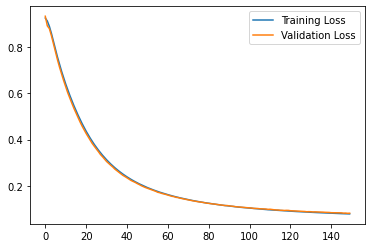

In [19]:
import matplotlib.pyplot as plt

# %matplotlib_inline
%config inlineBackend.figure_format = 'retina'

plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.legend(frameon=True)

(256, 256)
(256, 256)


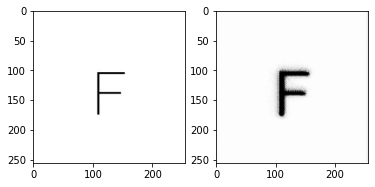

(256, 256)
(256, 256)


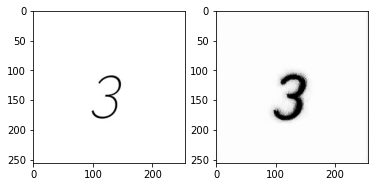

(256, 256)
(256, 256)


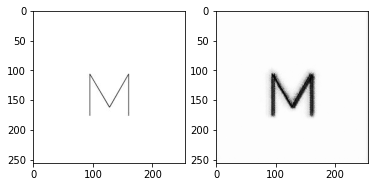

In [20]:
import cv2
out_img = torch.squeeze(output.cpu().data)
# print(out_img)

for i in range(3):
    im = torch.squeeze(image[i]).cpu().numpy()
    print(im.shape)
    out_im = out_img[i].numpy()
    plt.subplot(1,2,1)
    # plt.imshow(np.transpose(im, (1, 2, 0)))
    plt.imshow(im, cmap = 'gray')
    plt.subplot(1,2,2)
    # plt.imshow(np.transpose(out_im, (1, 2, 0)))
    plt.imshow(out_im, cmap='gray')
    print(out_im.shape)
    plt.show()

### 6. Test 

In [21]:
class test_dataset(torch.utils.data.Dataset):
    def __init__(self, x_dir, transform=None):
        super().__init__()
        self.transforms = transform
        self.x_img = x_dir  

    def __len__(self):
        return len(self.x_img)

    def __getitem__(self, idx):
        x_img = self.x_img[idx]
        X_img = cv2.imread(x_img)
        X_img= cv2.cvtColor(X_img, cv2.COLOR_BGR2GRAY)

        
        X_img=np.expand_dims(X_img, 2)


        if self.transforms != None:
            aug = self.transforms(image = X_img)
            x_image = aug['image']

            x_image = np.transpose(x_image, (2, 0, 1))
            
        return x_image

In [22]:
test_csv = pd.read_csv('./data/test.csv')

test_files = test_csv['input']

In [23]:
test_augmetations = albumentations.Compose([
                              albumentations.Resize(256, 256),
                              alb.augmentations.transforms.Normalize(mean=(0.5), std=(0.5))
                              ],additional_targets={'label':'image'})

In [24]:
test_data = test_dataset(test_files, transform = test_augmetations)

In [25]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=True, num_workers=0, drop_last=True)

In [26]:
mo = torch.load('./model/unet_L1loss_sgd3.pkl')
# mo

In [27]:
with torch.no_grad():
    for im in test_loader:
        # print(im)
        im = im.to(device)
        # label = label.to(device)
        out = mo(im)

torch.Size([16, 256, 256])


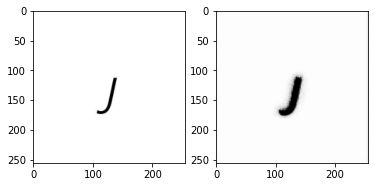

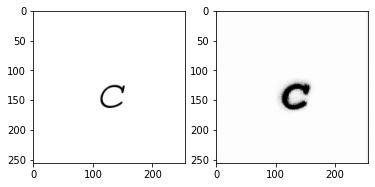

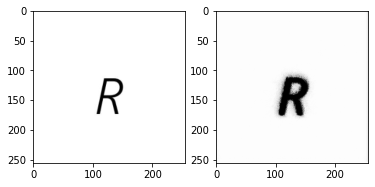

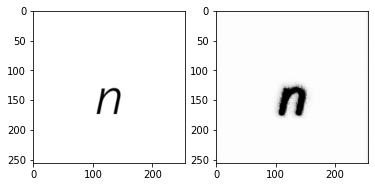

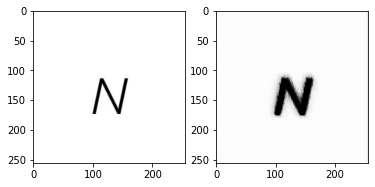

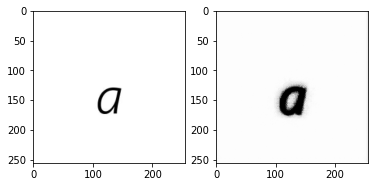

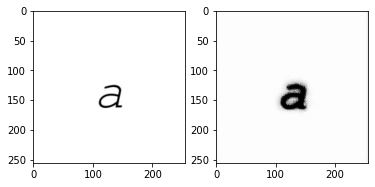

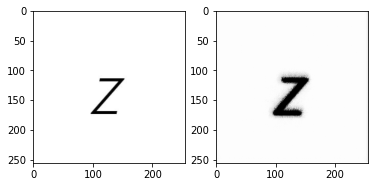

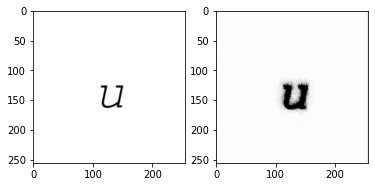

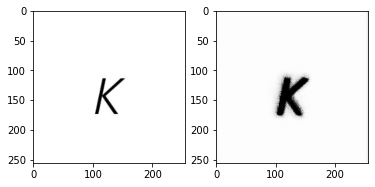

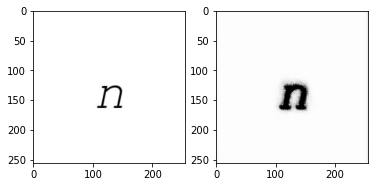

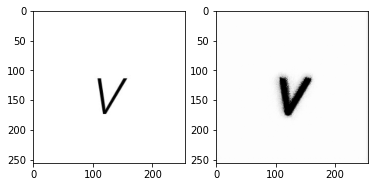

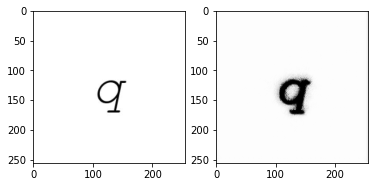

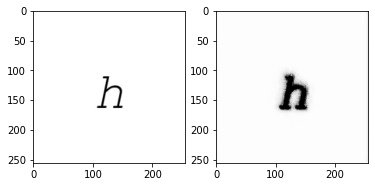

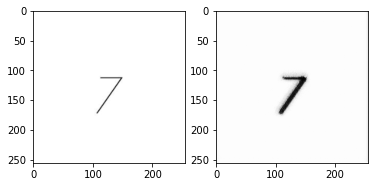

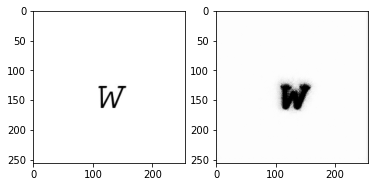

In [28]:
o = torch.squeeze(out.cpu().data)
print(o.size())

for i in range(16):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(im[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(o[i].numpy(),cmap='gray')
    # plt.imshow(np.transpose(out_im, (1, 2, 0)))
    plt.show()